In [2]:
#### load packages, *.h5 folder and exp.h5 file location
%matplotlib widget

from essential_func import *
qgrid2 = np.hstack([np.arange(0.005, 0.0499, 0.001), np.arange(0.05, 0.099, 0.002), np.arange(0.1, 3.2, 0.005)])

samples_csv                = 'data_directory.csv'
default_sample_dir         = 'Mar-2023-Sample#1898'       # 'July-2021-Sample#6'    '21-Nov'   'July-sorted'   '20-Dec'    '22-Oct'   'Oct-2022-1971'   'Mar-2023-Sample#1948'
csv_and_code_abs_directory = '/Users/bashit.a/Documents/Alzheimer/Codes/'

dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = default_sample_dir, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)

Python directory is set to load samples from : Mar-2023-Sample#1898


Output()

None

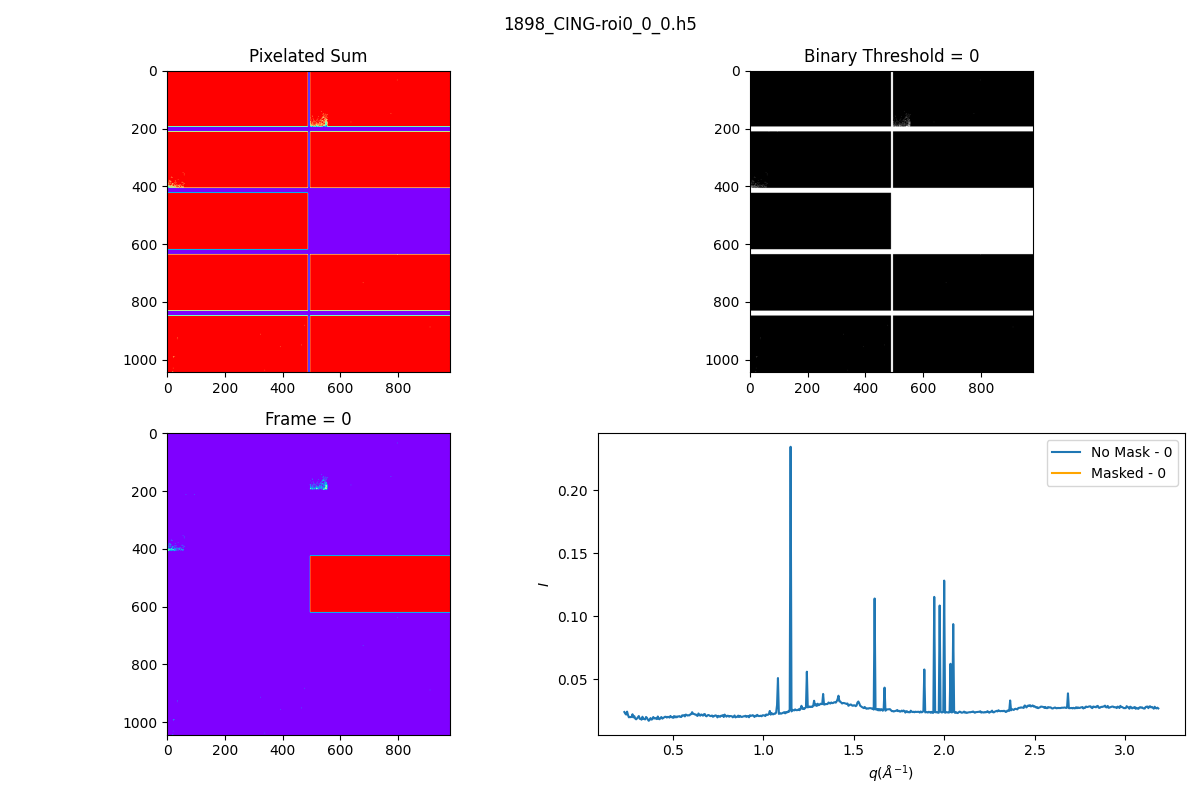

In [55]:
### load pixalated sum either directly from h5 file or already stored pixalted sum npz file -------- ##### (Independent Cell) - loading from file

%matplotlib widget

## specs/Slider Properties
AMIN_DEFAULT_VALUE = 0       # minimum value for the pixalated sum

frame_w = ipywidgets.IntSlider(value=0, min=0, max=3600, step=1, description = 'Frame', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
a_min_w = ipywidgets.fixed(value=AMIN_DEFAULT_VALUE)
a_max_w = ipywidgets.FloatSlider(value=50, min=0,     max=100, step=1, description = 'a_max', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
thr_w   = ipywidgets.IntSlider(value=AMIN_DEFAULT_VALUE,    min=AMIN_DEFAULT_VALUE, max=10, step=1, description = 'thr', continuous_update=False, layout=ipywidgets.Layout(width='50%'))
ipywidgets.jslink((a_max_w,'value'),(thr_w,'max'))           # make sure threshold's maximum value doesn't exceed a_max value

f, axs = plt.subplots(nrows=2,ncols=2,figsize=(12,8), )


def waxs_thresholding(file, a_min, a_max, thr, frame):
    global f, axs
    f.num=f'{file}'
    
    # spec
    dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')

    ## you don't need azimuthal averaging of the original file to do masking
    AMAX_DEFAULT_VALUE = np.median(dset_waxs_sum) ; 
    AMAX_MIN_VALUE = dset_waxs_sum.min() ; 
    AMAX_MAX_VALUE = np.percentile(dset_waxs_sum, 99);  
    AMAX_SLIDER_STEP = 100;    # maximum values for the pixalated sum
    # valid_range_min, valid_range_max = (0,10)   # just for WAXS Display purpose

    n_patterns = list(map(lambda x,y: x*y, *zip(width_height(file))))[0]   # calculate number of frames
    frame_w.max = n_patterns-1
    
    a_max_w.max   = AMAX_MAX_VALUE
    a_max_w.step  = AMAX_SLIDER_STEP

    thr_w.max = a_max_w.value

    # load waxs frame data 
    with h5py.File(file,'r') as hdf:
        dset_waxs = hdf.get(f'{h5_top_group(file)}/primary/data/pilW2_image')         # waxs data read from h5 file
        dset_waxs = np.array(dset_waxs[frame])
        
    args = (dset_waxs_sum, a_min, a_max, thr)
    dset_waxs_thr, gray_img, thr_fr_img = threshold_patch_one_frame(dset_waxs, args = args)
    
    #### plot thresholded pixalated sum
    axs[0,0].clear()
    im = axs[0,0].imshow(dset_waxs_thr, cmap = 'rainbow')       #plt.colorbar(im, fraction=0.046, pad=0.04)  

    axs[0,0].set_title('Pixelated Sum')

    #### plot global thresholding 
    axs[0,1].clear()
    im = axs[0,1].imshow(gray_img, cmap='gray')       
    axs[0,1].set_title(f'Binary Threshold = {thr}')

    axs[1,0].clear() 
    axs[1,1].clear()
    patching(file, frame, qgrid2, args=args, axes = (f,[axs[1,0], axs[1,1]]), method = 'thresholding', exp_folder = exp_folder  )

    print('File = ', file, 'a_min = ', a_min, 'a_max = {:0.2f}'.format(a_max), 'thr = ', thr)

### change dropdown_file lists when directory is changed
dropdown_dir   = ipywidgets.Dropdown(options= dropdown_name_list,           value = default_sample_dir,              description='Folder ',       disabled=False)
dropdown_file  = ipywidgets.Dropdown(options= cwd_files_search_with(seek_str='.h5', search_where = 'end', directory = cwd), value = cwd_files_search_with(seek_str='.h5', search_where = 'end', directory = cwd)[0], description='File ',         disabled=False)

def update_samples_list(*args):
    global cwd, exp_folder, dropdown_name_list
    dropdown_name, dropdown_name_list, cwd, exp_folder = change_python_path(dropdown_name = dropdown_dir.value, csv_file_location = csv_and_code_abs_directory, samples_csv = samples_csv)
    dropdown_file.options = cwd_files_search_with('.h5')
    dropdown_file.value = cwd_files_search_with('.h5')[0]
dropdown_dir.observe(update_samples_list)

out = ipywidgets.interactive_output(waxs_thresholding, {'file':dropdown_file , 'a_min': a_min_w, 'a_max':a_max_w, 'thr':thr_w, 'frame':frame_w})
ui = display(ipywidgets.VBox([dropdown_dir, dropdown_file, a_max_w, thr_w, frame_w, out]))

display(out, ui)

frame information extraction completes with _SAXS shape (1, 1043, 981) _WAXS shape (1, 1043, 981)...
Circular averaging starts now ... 
1898_HIPPO-roi0_0_0_masked_854.h5 total 1-d averaging time 0.4874701249937061 seconds


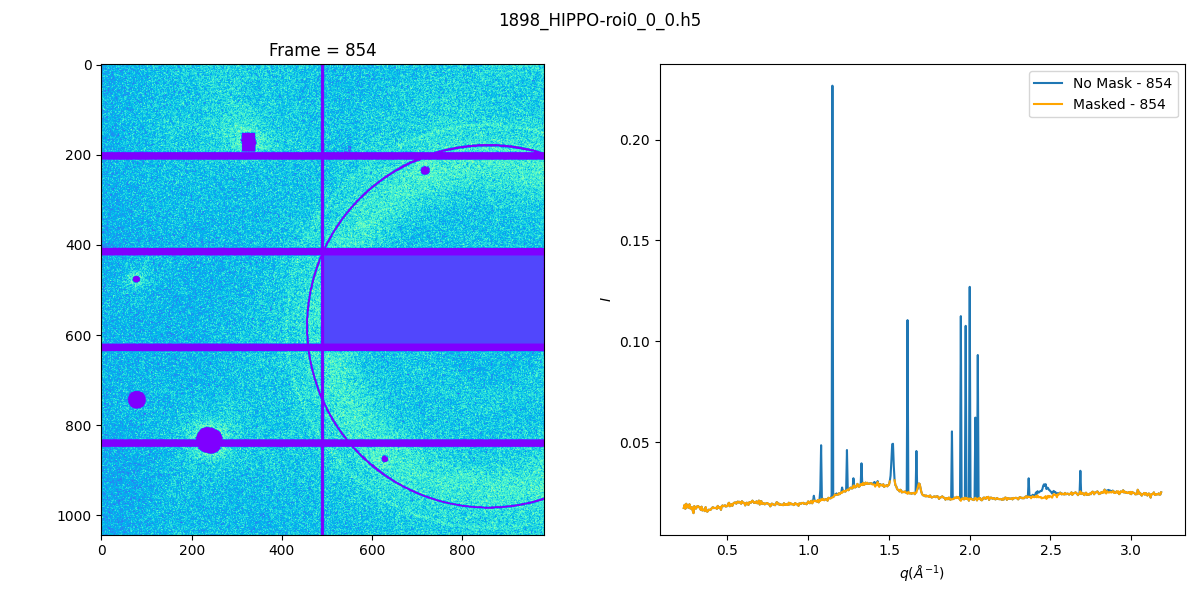

In [56]:
############### -------- configure patch size and copy the pathces tuplte to the next cell for computing 1-d averaging for all frames ------------- ################### (Independent Cell)
%matplotlib widget
frame = 854         # possible_bkg frame
file = "1898_HIPPO-roi0_0_0.h5"

dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')
patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[341,193]]
              ]

thr_args =  dset_waxs_sum, 0, 15634.00, 15344
args = (thr_args, patches_arg)

patching(file, frame, qgrid2, args=args, method = 'thr_rec_circ_patch', exp_folder = exp_folder);

In [3]:
##### --------- 1-d averaging after thresholding for one file - takes longer time  --------- (Independent Cell)
### spec
file = "1898_HIPPO-roi0_0_0.h5"
dset_waxs_sum = loading_dset_waxs_sum(file, load_from = 'npz')
patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[350,193]]
              ]

thr_args =  dset_waxs_sum, 0, 15634.00, 15350
args = (thr_args, patches_arg)

### computation
masked_file = circ_avg_from_patches(file, qgrid2, args= args, method = 'thr_rec_circ_patch', exp_folder = exp_folder  )

1898_HIPPO-roi0_0_0_masked.h5 is being created in /Volumes/HDD/BNL-Data/Mar-2023/1898 ...
1898_HIPPO-roi0_0_0_masked.h5 copy is done
1898_HIPPO-roi0_0_0_masked.h5 Loading data into a numpy array started 
1898_HIPPO-roi0_0_0_masked.h5 Loading data into a numpy array finished in 60.60935624999999 seconds
1898_HIPPO-roi0_0_0_masked.h5 Patching Started 
1898_HIPPO-roi0_0_0_masked.h5 Patching finished in 45.30028229200002 seconds
1898_HIPPO-roi0_0_0_masked.h5 patched pilW2_image dataset creation staring ... 
1898_HIPPO-roi0_0_0_masked.h5 patched pilW2_image dataset creation finished in 114.196534708 seconds
Circular averaging starts now ... 


/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:301: RuntimeWarning: invalid value encountered in divide
  s0.data = d_tot/w_tot
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:302: RuntimeWarning: invalid value encountered in divide
  s0.err = np.sqrt(e_tot)/w_tot
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:281: RuntimeWarning: divide by zero encountered in divide
  wt = 1/d1.err[idx]**2
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:282: RuntimeWarning: invalid value encountered in multiply
  d_tot[idx] += wt*d1.data[idx]
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:283: RuntimeWarning: invalid value encountered in multiply
  e_tot[idx] += d1.err[idx]**2*wt**2
/Users/bashit.a/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/py4xs/hdf.py:301: RuntimeWarning: invalid value encountered in d

data received: sn=1898_HIPPO-roi0_0_0, fr1=0
data received: sn=1898_HIPPO-roi0_0_0, fr1=472
data received: sn=1898_HIPPO-roi0_0_0, fr1=944
data received: sn=1898_HIPPO-roi0_0_0, fr1=1416
data received: sn=1898_HIPPO-roi0_0_0, fr1=1888
data received: sn=1898_HIPPO-roi0_0_0, fr1=2360
data received: sn=1898_HIPPO-roi0_0_0, fr1=2832
data received: sn=1898_HIPPO-roi0_0_0, fr1=3304
1898_HIPPO-roi0_0_0_masked.h5 total 1-d averaging time 507.969151125 seconds


In [ ]:
# 1-d averaging after rectangular and/or circular patches for one file  (Independent Cell)
### spec
source_file = "2048_B8.h5"
patches = [
#                              [[800, 0], [980, 150]],
#                              [[245, 0], [385, 130]],
          ]

### computation
masked_file = circ_avg_from_patches(source_file, qgrid2, patches)

In [7]:
## patching information retrival from _masked.h5 file    (Independent Cell)
#specs
file   = "1898_HIPPO-roi0_0_0_masked.h5"
method = 'thr_rec_circ_patch'

# computation
try: 
    patches = get_patch_attributes(masked_file, method)   # 'thresholding'   'rec_circ_patch'   'thr_rec_circ_patch'
    print(patches)
except: 
    print(f'{file} does not have patches information on the processed folder')

([0, 15634.0, 15350], [[[79, 743], 20], [[312, 152], [350, 193]]])


In [ ]:
### check config.json file integrity     (Independent Cell) - no error no problem
No_error_no_prb = get_json_str_data('sample-6-july-2021-withthreshold.json');  # config-mar-2023-1898-withthreshold.json

In [ ]:
# 1-d averaging after patches for ALL files in the current directory   (Independent Cell)

# specs
data = get_json_str_data("config-mar-24-withthreshold.json")
method = 'thresholding'                                        # 'thresholding' or 'rec_circ_patch'

### do masking and 1-d averaging (Lin Yang's code by BNL used here for 1-d averaging)
files = []

for file in data['files']:
    source_file = file['name']
    try: 
        if method == 'rec_circ_patch':
            patches = file['patches']
            masked_file = circ_avg_from_patches(source_file, qgrid2, patches) 
        elif method == 'thresholding': 
            patches = file['threshold']
            print(file, 'thresholded to -->', patches)
            masked_file = circ_avg_from_patches(source_file, qgrid2, args=tuple(patches), method = 'thresholding')  # args must be of tuple
    except: continue
    files.append((source_file, masked_file))

print(f'Successfully created (source file, masked file) \n\n')
[print(idx+1, '. ', s, '--->' ,t) for idx, (s,t) in enumerate(files)]
pass

In [42]:
# specs

data = get_json_str_data(os.path.join(cwd, "config-mar-2023-1898-withthreshold.json"))
method = 'thr_rec_circ_patch'                                      # 'thresholding' or 'rec_circ_patch' or 'thr_rec_circ_patch' 


### do masking and 1-d averaging (Lin Yang's code by BNL used here for 1-d averaging)
files = []

for file in data['files']:
    source_file = file['name']
    try: 
        if method == 'rec_circ_patch':
            patches = file['patches']
            print(source_file, 'patches to -->', patches)
            # masked_file = circ_avg_from_patches(source_file, qgrid2, patches) 
        elif method == 'thresholding': 
            patches = file['threshold']
            print(source_file, 'thresholded to -->', patches)
            # masked_file = circ_avg_from_patches(source_file, qgrid2, args=tuple(patches), method = 'thresholding')  # args must be of tuple
        elif method == 'thr_rec_circ_patch':
            if file['patches'] or file['threshold']:   # making sure either or both pathes and thresholding exists otherwise skip 
                dset_waxs_sum = loading_dset_waxs_sum(source_file, load_from = 'npz')
                patches_arg = file['patches']
                thr_args    =  dset_waxs_sum, *file['threshold']
                args = (thr_args, patches_arg)
                # print(source_file, 'thr_rec_circ_patch to -->', args)

                # masked_file = circ_avg_from_patches(file, qgrid2, args = args, method = 'thr_rec_circ_patch', exp_folder = exp_folder  )
            else:
                continue
    except: 
        continue
    files.append((source_file, masked_file))

print(f'Successfully created (source file, masked file) \n\n')
[print(idx+1, '. ', s, '--->' ,t) for idx, (s,t) in enumerate(files)]

Successfully created (source file, masked file) 


1 .  1898_CING-roi0_0_0.h5 ---> None
2 .  1898_HIPPO-roi0_0_0.h5 ---> None


[None, None]

Minimum, Maximum Iq : 0.0153, 0.0336


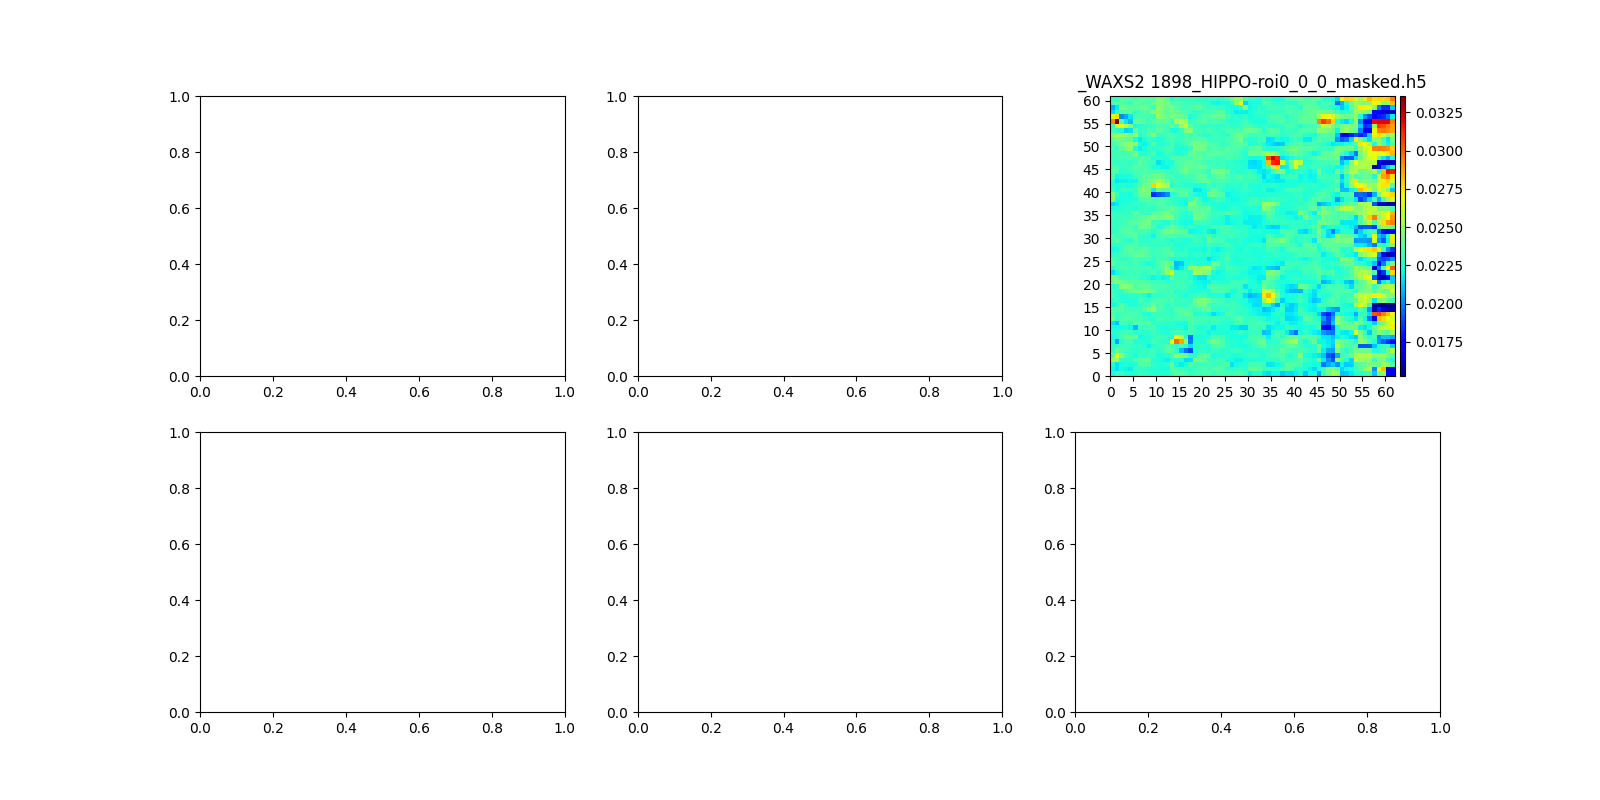

Minimum, Maximum Iq : 0.3736, 82.9140


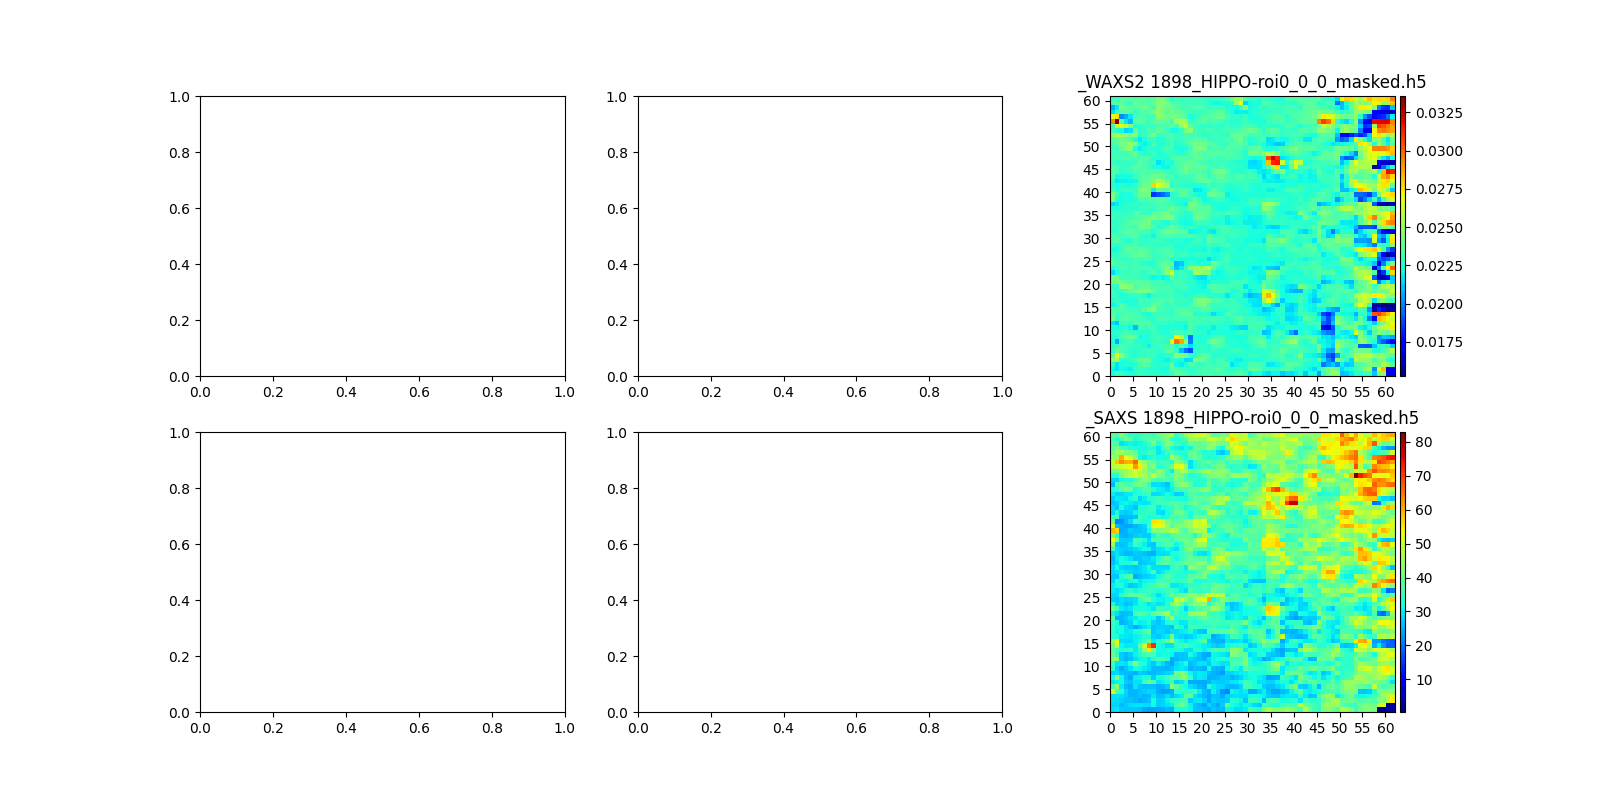

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=3781), Output()), _…

In [51]:
### 1d circularly averaged data for masked file
%matplotlib widget
import ipywidgets   # from IPython.display import display; display(amp)
from IPython.display import display, clear_output

# anyinitialized masked_file will be removed beginning of the cell
try : del source_file
except NameError: pass

# specs 
# source_file = "1898_HIPPO-roi0_0_0.h5"         # comment out to avoid plotting  # must input source file name   '1934_B8_masked.h5'
masked_file = "1898_HIPPO-roi0_0_0_masked.h5"          # "2048_B8_masked.h5"
scattering = ('_SAXS', '_WAXS2',)
frames = None


# computation
Width, Height = width_height(masked_file)    # considering the fact that width and height is same for source and masked file
n_patterns = Width*Height

f,axs = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
# plot_heat_map_from_file(source_file, qgrid2, scatterings = (scattering[1],), cmap = 'viridis', args = (f, axs[0,1]))
plot_heat_map_from_file(masked_file, qgrid2, scatterings = (scattering[1],) , cmap = 'jet', args = (f, axs[0,2]), data_binning=False, bins = np.fromiter(drange(0, 0.04, 0.001), float) )  # discrete_cmap(N=5, base_cmap = 'cubehelix')     viridis
plot_heat_map_from_file(masked_file, qgrid2, scatterings = (scattering[0],) , cmap = 'jet', args = (f, axs[1,2]), data_binning=False, bins = np.fromiter(drange(0, 20, 0.5), float) )  # discrete_cmap(N=5, base_cmap = 'cubehelix')     viridis


def update_plot(frame):
    axs[0,0].clear()
    axs[1,0].clear()

    axs[0,0].set_yscale('log')
    axs[1,0].set_yscale('log')

    axs[0,0].set_xlabel('q'); axs[0,0].set_ylabel('log(I)');
    axs[1,0].set_xlabel('q'); axs[1,0].set_ylabel('log(I)');
    
    Iq_M_SAXS = read_Iq(masked_file, scattering[0])   # Source must be read even you do mask or not
    Iq_M_WAXS = read_Iq(masked_file, scattering[1])   # Source must be read even you do mask or not

    try:
        source_file
        if source_file ==  masked_file:
            axs[0,0].plot(qgrid2, Iq_S_WAXS[frame], label = f' Fr- {frame}');
            waxs_diff_image(masked_file, frame, f, axs[0,1])

            axs[1,0].plot(qgrid2, Iq_S_SAXS[frame], label = f' Fr- {frame}');
            saxs_diff_image(masked_file, frame, f, axs[1,1])

        else:
            Iq_S_SAXS = read_Iq(source_file, scattering[0])
            Iq_S_WAXS = read_Iq(source_file, scattering[1])
            
            axs[0,0].plot(qgrid2, Iq_S_WAXS[frame], label = f'Before Mask Fr- {frame}');
            axs[0,0].plot(qgrid2, Iq_M_WAXS[frame], label = f'After Mask Fr- {frame}'); 
            waxs_diff_image(masked_file, frame, f, axs[0,1])

            axs[1,0].plot(qgrid2, Iq_S_SAXS[frame], label = f'Before Mask Fr- {frame}');
            axs[1,0].plot(qgrid2, Iq_M_SAXS[frame], label = f'After Mask Fr- {frame}');
            saxs_diff_image(masked_file, frame, f, axs[1,1])

    except NameError:
        axs[0,0].plot(qgrid2, Iq_M_WAXS[frame], label = f' Fr- {frame}');
        waxs_diff_image(masked_file, frame, f, axs[0,1])

        axs[1,0].plot(qgrid2, Iq_M_SAXS[frame], label = f' Fr- {frame}');
        saxs_diff_image(masked_file, frame, f, axs[1,1])

    axs[0,0].legend()
    axs[1,0].legend()
    plt.suptitle(f'{masked_file}')
    plt.tight_layout()
    
if frames == None :
    frame = ipywidgets.IntSlider(min=0, max=n_patterns-1, value=0, description = "Frame", continuous_update=False)
else :
    frame = ipywidgets.SelectionSlider(value = frames[0], options = frames, continuous_update=False)

ipywidgets.interactive(update_plot, frame=frame)

In [75]:
file = "1898_HIPPO-roi0_0_0_masked.h5"
patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[341,193]]
              ]


thr_args =  dset_waxs_sum, 0, 15634.00, 15344
args = (thr_args, patches_arg)
thr_args = thr_args[1:]                  # dset_waxs_sum omitted, thr_args = [amin, amax, threshold]


with h5py.File(file,'r+') as hdf:
    dset = hdf.get(f'{h5_top_group(file)}/processed')              # Iq = hdf.get('2048_B16/processed')
    dset.attrs['threshold'] = thr_args    # here args = [amin, amax, threshold]
    dset.attrs['patches'] = json.dumps(patches_arg)

In [14]:
source_file = "1898_HIPPO-roi0_0_0.h5"
masked_file = "1898_HIPPO-roi0_0_0.h5"


patches_arg = [
                             [[79,  743], 20 ],
                             [[312,152],[341,193]]
              ]
dset_waxs_sum = loading_dset_waxs_sum(source_file, load_from = 'npz')
thr_args =  dset_waxs_sum, 0, 15634.00, 15344
args = (thr_args, patches_arg)

args = thr_args[1:]

set_patch_attributes(masked_file, patches_arg, method = 'rec_circ_patch')

'patching information written on the h5 file processed directory'